# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [40]:
%matplotlib inline

import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D, Lambda
import matplotlib.pyplot as plt

In [2]:
import tensorflow.keras.datasets.mnist as input_data
(x_train, _), (x_test, y_test) = input_data.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

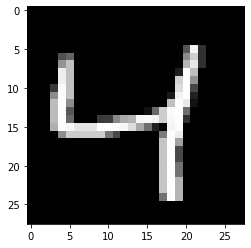

In [3]:
img = x_train[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

In [7]:
#Normalize the images
x_train = x_train/255.
x_test = x_test/255.

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **transposed convolution** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. 
In TensorFlow, this is easily done with [`UpSampling2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D) layer, followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling. The `UpSampling2D` layer allways generates an even shape. To recreate the network in the image the first upsampling of the decoder needs to be a special layer called [`Lambda`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda). With this Layer it is possible to call tensorflow functions within a sequential model. To resize the image from 4x4x8 to 7x7x8 we will call the [`tf.image.resize_images`](https://www.tensorflow.org/api_docs/python/tf/image/resize) function

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by a factor of 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, this is the default value of the `UpSampling2D` layer and doesn't need to be specified. For convolutional layers, use [`Conv2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D). For example, you would write `model.add(Conv2D(32, (5,5), padding='same', activation='relu'))` for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use [`MaxPooling2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPooling2D).

In [41]:
model = Sequential()
### Encoder
model.add(Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(28,28,1)))
# Now 28x28x16
model.add(MaxPooling2D((2,2), (2,2), padding='same'))
# Now 14x14x16
model.add(Conv2D(8, (3,3), padding='same', activation='relu'))
# Now 14x14x8
model.add(MaxPooling2D((2,2), (2,2), padding='same'))
# Now 7x7x8
model.add(Conv2D(8, (3,3), padding='same', activation='relu'))
# Now 7x7x8
model.add(MaxPooling2D((2,2), (2,2), padding='same'))
# Now 4x4x8

### Decoder
model.add(Lambda( lambda image: tf.image.resize(image, [7,7], method='nearest')))
# Now 7x7x8
model.add(Conv2D(8, (3,3), padding='same', activation='relu'))
# Now 7x7x8
model.add(UpSampling2D((2, 2)))
# Now 14x14x8
model.add(Conv2D(8, (3,3), padding='same', activation='relu'))
# Now 14x14x8
model.add(UpSampling2D((2, 2)))
#Now 28x28x8
model.add(Conv2D(16, (3,3), padding='same', activation='relu'))
#Now 28x28x16
model.add(Conv2D(1, (3,3), padding='same', activation='sigmoid'))
#Now 28x28x1

model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_103 (Conv2D)          (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 4, 4, 8)           0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 7, 7, 8)         

In [42]:
from tensorflow.keras.optimizers import Adam

# compile the model
model.compile(optimizer="adam", loss='binary_crossentropy')

## Training

As before, here wi'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [43]:
epochs = 20
batch_size = 200

model.fit(x_train, x_train,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True)

Train on 60000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 47us/sample - loss: 0.2249
Epoch 2/20
60000/60000 [==============================] - 2s 38us/sample - loss: 0.1367
Epoch 3/20
60000/60000 [==============================] - 2s 38us/sample - loss: 0.1251
Epoch 4/20
60000/60000 [==============================] - 2s 39us/sample - loss: 0.1193
Epoch 5/20
60000/60000 [==============================] - 2s 39us/sample - loss: 0.1156
Epoch 6/20
60000/60000 [==============================] - 2s 39us/sample - loss: 0.1127
Epoch 7/20
60000/60000 [==============================] - 2s 38us/sample - loss: 0.1104
Epoch 8/20
60000/60000 [==============================] - 2s 38us/sample - loss: 0.1085
Epoch 9/20
60000/60000 [==============================] - 2s 39us/sample - loss: 0.1069
Epoch 10/20
60000/60000 [==============================] - 2s 38us/sample - loss: 0.1054
Epoch 11/20
60000/60000 [==============================] - 2s 38us/sample - loss: 0.1041
Epoch 1

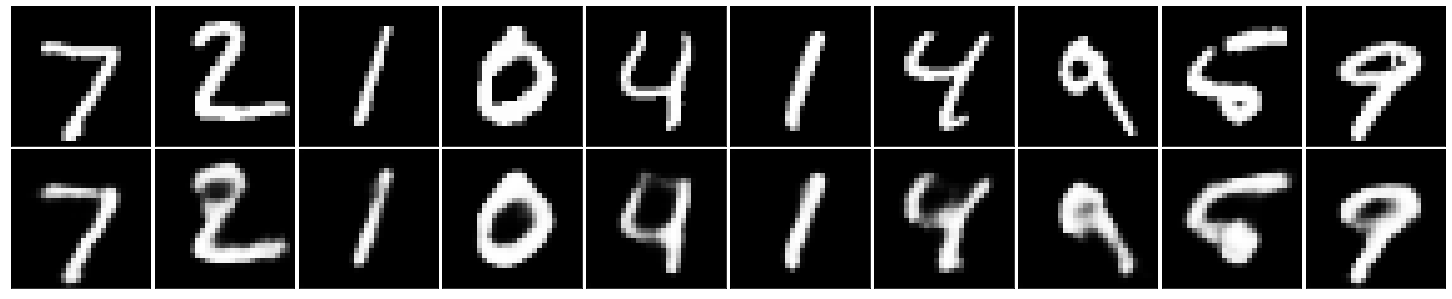

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = x_test[:10]
reconstructed = model.predict(in_imgs)
for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [45]:
model = Sequential()
### Encoder
model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(28,28,1)))
# Now 28x28x32
model.add(MaxPooling2D((2,2), (2,2), padding='same'))
# Now 14x14x32
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
# Now 14x14x32
model.add(MaxPooling2D((2,2), (2,2), padding='same'))
# Now 7x7x32
model.add(Conv2D(16, (3,3), padding='same', activation='relu'))
# Now 7x7x16
model.add(MaxPooling2D((2,2), (2,2), padding='same'))
# Now 4x4x16

### Decoder
model.add(Lambda( lambda image: tf.image.resize(image, [7,7], method='nearest')))
# Now 7x7x16
model.add(Conv2D(16, (3,3), padding='same', activation='relu'))
# Now 7x7x16
model.add(UpSampling2D((2, 2)))
# Now 14x14x16
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
# Now 14x14x32
model.add(UpSampling2D((2, 2)))
#Now 28x28x32
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
#Now 28x28x32
model.add(Conv2D(1, (3,3), padding='same', activation='sigmoid'))
#Now 28x28x1

model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_124 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_125 (Conv2D)          (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 4, 4, 16)          0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 7, 7, 16)        

In [46]:
# compile the model
model.compile(optimizer="adam", loss='binary_crossentropy')

In [47]:
epochs = 100
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5

# Add random noise to the input images
noisy_imgs = x_train + noise_factor * np.random.randn(*x_train.shape)
# Clip the images to be between 0 and 1
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

model.fit(noisy_imgs, x_train,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True)

Train on 60000 samples
Epoch 1/100
60000/60000 [==============================] - 4s 71us/sample - loss: 0.2271
Epoch 2/100
60000/60000 [==============================] - 4s 60us/sample - loss: 0.1562
Epoch 3/100
60000/60000 [==============================] - 4s 60us/sample - loss: 0.1420
Epoch 4/100
60000/60000 [==============================] - 4s 60us/sample - loss: 0.1342
Epoch 5/100
60000/60000 [==============================] - 4s 61us/sample - loss: 0.1291
Epoch 6/100
60000/60000 [==============================] - 4s 60us/sample - loss: 0.1253
Epoch 7/100
60000/60000 [==============================] - 4s 60us/sample - loss: 0.1224
Epoch 8/100
60000/60000 [==============================] - 4s 60us/sample - loss: 0.1202
Epoch 9/100
60000/60000 [==============================] - 4s 60us/sample - loss: 0.1184
Epoch 10/100
60000/60000 [==============================] - 4s 61us/sample - loss: 0.1170
Epoch 11/100
60000/60000 [==============================] - 4s 61us/sample - loss: 0.1

60000/60000 [==============================] - 4s 61us/sample - loss: 0.0998
Epoch 92/100
60000/60000 [==============================] - 4s 61us/sample - loss: 0.0997
Epoch 93/100
60000/60000 [==============================] - 4s 59us/sample - loss: 0.0997
Epoch 94/100
60000/60000 [==============================] - 4s 61us/sample - loss: 0.0997
Epoch 95/100
60000/60000 [==============================] - 4s 61us/sample - loss: 0.0995
Epoch 96/100
60000/60000 [==============================] - 4s 61us/sample - loss: 0.0996
Epoch 97/100
60000/60000 [==============================] - 4s 61us/sample - loss: 0.0994
Epoch 98/100
60000/60000 [==============================] - 4s 61us/sample - loss: 0.0995
Epoch 99/100
60000/60000 [==============================] - 4s 61us/sample - loss: 0.0994
Epoch 100/100
60000/60000 [==============================] - 4s 61us/sample - loss: 0.0995


## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprising great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

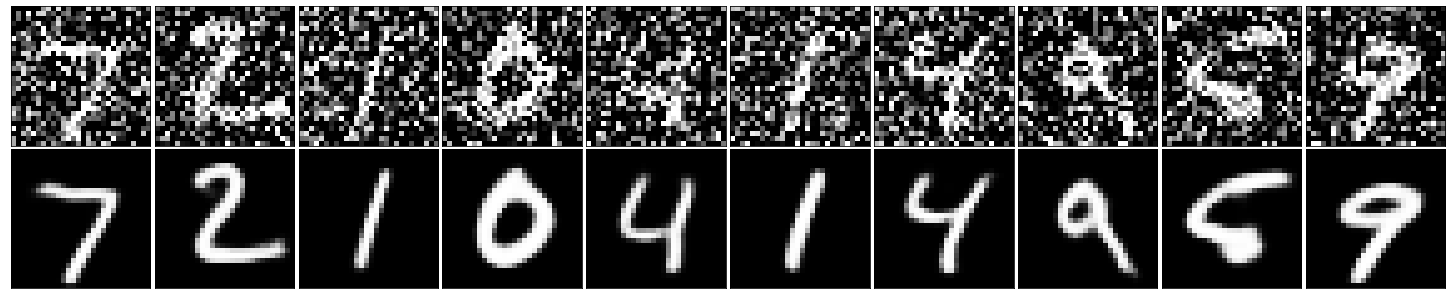

In [49]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = x_test[:10]
noisy_imgs = x_test + noise_factor * np.random.randn(*x_test.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = model.predict(in_imgs)

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)